In [1]:
tr_path = '../../Data/ml2021spring-hw1/covid.train.csv' # training data path
tt_path = '../../Data/ml2021spring-hw1/covid.test.csv' # testing data path

import numpy as np
import pandas as pd

import os
# 遍历指定目录下的所有文件
for dirname, _, filenames in os.walk('../../Data/ml2021spring-hw1'):
    # 打印出所有文件的路径
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../Data/ml2021spring-hw1\covid.test.csv
../../Data/ml2021spring-hw1\covid.train.csv
../../Data/ml2021spring-hw1\sampleSubmission.csv


## 导入库

In [4]:
import torch
# 导入PyTorch库
import torch.nn as nn
# 导入PyTorch神经网络模块
from torch.utils.data import Dataset, DataLoader

# 导入PyTorch数据加载模块
import numpy as np
# 导入NumPy库
import csv
# 导入csv模块
import os

# 导入os模块
import matplotlib.pyplot as plt
# 导入matplotlib库
from matplotlib.pyplot import figure

# 从matplotlib.pyplot库中导入figure函数
myseed = 20250419
# 设置随机种子
torch.backends.cudnn.deterministic = True
# 设置PyTorch的CUDNN后端为确定性模式
torch.backends.cudnn.benchmark = False
# 设置PyTorch的CUDNN后端为非基准模式
np.random.seed(myseed)
# 设置NumPy的随机种子
torch.manual_seed(myseed)
# 设置PyTorch的随机种子
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [6]:
# 定义一个函数，用于获取设备信息
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

In [46]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss)
    
    Args:
        loss_record (dict): A dictionary containing the training and development loss records.
            It should have two keys: 'train' and 'dev', each corresponding to a list of loss values.
        title (str): The title of the plot. Default is an empty string.
    
    Returns:
        None: This function does not return anything, it only plots the learning curve.
    '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


In [ ]:
def plot_pred(dv_set, model, device, lim = 35., preds=None, targets=None):
    # 如果preds和targets为空，则进行预测和目标值的计算
    if preds is None or targets is None:
        # 将模型设置为评估模式
        model.eval()
        # 初始化preds和targets列表
        preds, targets = [], []
        # 遍历验证集
        for x, y in dv_set:
            # 将输入数据和目标值移动到指定设备上
            x, y = x.to(device), y.to(device)
            # 关闭梯度计算
            with torch.no_grad():
                # 进行预测
                pred = model(x)
                # 将预测结果和目标值添加到列表中
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        # 将预测结果和目标值拼接成张量
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    # 创建一个5x5大小的图像
    figure(figsize=(5,5))
    # 在图像上绘制散点图，x轴为targets，y轴为preds，颜色为红色，透明度为0.5
    plt.scatter(targets, preds, c='r', alpha=0.5)
    # 绘制一条从(-0.2, -0.2)到(lim, lim)的直线，颜色为蓝色
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    # 设置x轴和y轴的范围
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    # 设置x轴和y轴的标签
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    # 设置图像标题
    plt.title('Ground Truth vs Predictions')
    # 显示图像
    plt.show()

In [16]:
import pandas as pd
import numpy as np

data = pd.read_csv(tr_path)
# 读取训练数据
x = data[data.columns[1:94]]
y = data[data.columns[94]]

In [17]:
# 导入SelectKBest类，用于选择最佳特征
from sklearn.feature_selection import SelectKBest
# 导入f_regression函数，用于计算特征与目标变量之间的相关性
from sklearn.feature_selection import f_regression

# 导入preprocessing模块，用于数据预处理
from sklearn import preprocessing

In [ ]:
# 对x进行归一化处理
x = (x - x.min()) / (x.max() - x.min())

# 选择前5个最佳特征
bestfeatures = SelectKBest(f_regression, k=5)
# 训练模型
fit = bestfeatures.fit(x,y)
# 获取每个特征的得分
dfscores = pd.DataFrame(fit.scores_)
# 获取每个特征的名称
dfcolumns = pd.DataFrame(x.columns)

# 将特征名称和得分合并为一个DataFrame
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# 设置DataFrame的列名
featureScores.columns = ['Specs','Score']  
# 打印得分最高的前15个特征
print(featureScores.nlargest(15,'Score'))

                 Specs          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191


In [32]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=True):
        """
        初始化COVID19数据集对象。

        参数:
        path (str): 数据文件的路径。
        mode (str): 数据集模式，'train'表示训练集，'test'表示测试集，默认为'train'。
        target_only (bool): 是否只使用目标变量，默认为True。
        """
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
            # feats = list(range(1, 40)) + [57, 75]
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # feats = list(range(1, 41)) + [57, 75]
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77] #上面挑选的最优特征
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            # 在确定参数后，使用所有数据进行训练，即训练集=验证集
            if mode == 'train':
                #indices = [i for i in range(len(data)) if i % 10 != 0]
                indices = [i for i in range(len(data))]
            elif mode == 'dev':
                #indices = [i for i in range(len(data)) if i % 10 == 0]
                indices = [i for i in range(len(data))]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        """
        根据给定的索引返回一个样本。

        参数:
        index (int): 样本的索引。

        返回:
        tuple 或 object: 如果是训练或验证模式，返回一个包含数据和目标的元组；如果是测试模式，只返回数据。
        """
        # 返回一个样本
        if self.mode in ['train', 'dev']:
            # 对于训练和验证模式
            return self.data[index], self.target[index]
        else:
            # 对于测试模式（没有目标）
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)


In [30]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' 
    生成一个数据集，然后将其放入数据加载器中。
    
    参数:
    path (str): 数据集的路径。
    mode (str): 数据集的模式，可以是'train'、'val'或'test'。
    batch_size (int): 每个批次的数据量。
    n_jobs (int, 可选): 数据加载器的并行工作进程数，默认为0。
    target_only (bool, 可选): 是否只加载目标数据，默认为False。
    
    返回:
    DataLoader: 构建好的数据加载器。
    '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # 构建数据集
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # 构建数据加载器
    return dataloader


In [22]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        """
        初始化神经网络模型。

        参数:
        input_dim (int): 输入特征的维度。
        """
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),  # 定义第一层全连接层，输入维度为input_dim，输出维度为32
            nn.BatchNorm1d(32),  # 对输出进行批量归一化
            nn.Dropout(p=0.2),  # 定义Dropout层，防止过拟合，p为丢弃概率
            nn.LeakyReLU(),  # 定义LeakyReLU激活函数
            nn.Linear(32, 1)  # 定义第二层全连接层，输入维度为32，输出维度为1
        )

        self.criterion = nn.MSELoss(reduction='mean')  # 定义均方误差损失函数，reduction为'mean'表示取平均值

    def forward(self, x):
        """
        前向传播函数，将输入数据通过网络进行处理并返回结果。

        参数:
        x (Tensor): 输入数据，通常是一个张量。

        返回:
        Tensor: 处理后的输出数据，张量的第1维被压缩。
        """
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        """
        计算损失函数，包括正则化损失和预测损失。
        
        参数:
        pred (Tensor): 预测值
        target (Tensor): 目标值
        
        返回:
        Tensor: 总损失
        """
        regularization_loss = 0
        for param in self.net.parameters():
            regularization_loss += torch.norm(param ** 2)
        return self.criterion(pred, target) + 0.00075 * regularization_loss


In [40]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


In [43]:
def dev(dv_set, model, device):
    """
    Evaluate the model on the given dataset.

    Parameters:
    dv_set (DataLoader): The dataset to evaluate the model on.
    model (nn.Module): The model to evaluate.
    device (torch.device): The device to run the evaluation on (cpu/cuda).

    Returns:
    float: The averaged loss over the dataset.
    """
    model.eval()                                # set model to evaluation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss


In [ ]:
def test(tt_set, model, device):
    """
    对给定的测试集进行评估，并返回预测结果。

    参数:
    tt_set (torch.utils.data.Dataset): 测试集数据。
    model (torch.nn.Module): 模型实例。
    device (torch.device): 计算设备，例如 'cpu' 或 'cuda'。

    返回:
    numpy.ndarray: 预测结果。
    """
    model.eval()  # 设置模型为评估模式
    preds = []  # 存储预测结果的列表
    for x in tt_set:
        x = x.to(device)  # 将数据移动到指定设备
        with torch.no_grad():  # 禁用梯度计算
            pred = model(x)  # 进行前向传播
            preds.append(pred.detach().cpu())  # 将预测结果从GPU移动到CPU并添加到列表
    preds = torch.cat(preds, dim=0).numpy()  # 将所有预测结果拼接成一个张量并转换为numpy数组
    return preds  # 返回预测结果


In [25]:
device = get_device()
os.makedirs('models', exist_ok=True)
target_only = True

config = {

    'n_epochs': 10000,
    'batch_size': 200,
    'optimizer': 'Adam',
    'optim_hparas' : {
        #'lr': 0.0001,                 
        #'momentum': 0.9,             
        #'weight_decay': 5e-4,
    },
    'early_stop': 500,
    'save_path': 'models/model.pth'
}

In [ ]:
# 准备训练集数据加载器
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
# 准备验证集数据加载器
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
# 准备测试集数据加载器
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


C:\Users\ChenYL\AppData\Local\Temp\ipykernel_39240\2859111026.py:56: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  / self.data[:, 40:].std(dim=0, keepdim=True)


In [38]:
model = NeuralNet(tr_set.dataset.dim).to(device) 

In [44]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 248.8105)
Saving model (epoch =    5, loss = 247.5065)
Saving model (epoch =    6, loss = 221.5155)
Saving model (epoch =    7, loss = 212.5713)
Saving model (epoch =    8, loss = 208.4369)
Saving model (epoch =    9, loss = 193.3290)
Saving model (epoch =   10, loss = 178.4546)
Saving model (epoch =   11, loss = 172.5027)
Saving model (epoch =   12, loss = 163.7283)
Saving model (epoch =   13, loss = 147.0965)
Saving model (epoch =   14, loss = 126.7522)
Saving model (epoch =   15, loss = 100.7735)
Saving model (epoch =   17, loss = 92.9555)
Saving model (epoch =   21, loss = 91.1885)
Saving model (epoch =   22, loss = 81.8207)
Saving model (epoch =   23, loss = 60.5777)
Saving model (epoch =   25, loss = 54.8197)
Saving model (epoch =   26, loss = 41.2461)
Saving model (epoch =   28, loss = 21.5833)
Saving model (epoch =   33, loss = 14.5519)
Saving model (epoch =   34, loss = 10.0205)
Saving model (epoch =   46, loss = 8.9646)
Saving model (epoch =

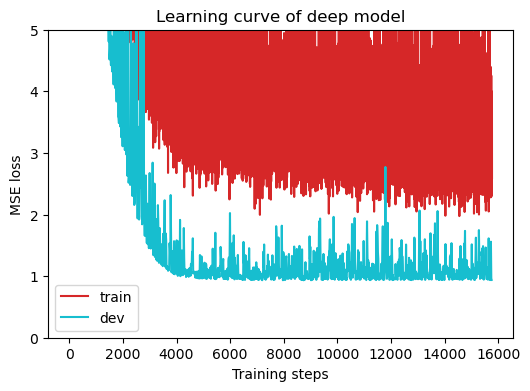

In [47]:
plot_learning_curve(model_loss_record, title='deep model')


C:\Users\ChenYL\AppData\Local\Temp\ipykernel_39240\1425700501.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(config['save_path'], map_location='cpu') 

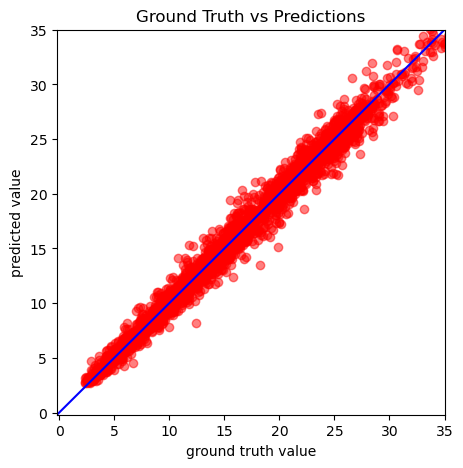

In [48]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [50]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, './submit.csv')         # save prediction file to pred.csv

Saving results to ./submit.csv
